# Git Clone GPSat
this is need if running in colab

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch
# TODO: clean up below

if IN_COLAB:
    
    import os
    import re

    # change to working directory
    work_dir = "/content"
    
    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)
    
    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)


cloning directory: :x-oauth-basic@github.com/CPOMUCL/GPSat
b''
changing directory to: /content/GPSat


## install the requirements

In [ ]:
if IN_COLAB:
    !pip install -r requirements.txt

Ignoring gpflow: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Windows"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Darwin" and platform_machine == "x86_64"' don't match your environment
Ignoring tensorflow-macos: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.8/379.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 5.8 M

## install the GPSat pacakge in editable mode

In [ ]:
if IN_COLAB:
    !pip install -e .

Obtaining file:///content/GPSat
  Preparing metadata (setup.py) ... done
  Running setup.py develop for GPSat



# import packages


In [ ]:
# simple inline example of OI
# NOTE: there is no smoothing of hyper parameters

import os
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data


# read in raw data


In [ ]:

# read in all the *_RAW.csv files in data/example
# - get files to read
raw_files = [get_data_path("example", i)
             for i in os.listdir(get_data_path("example")) if re.search("_RAW\.csv$", i)]

# read in, add source col
tmp = []
for rw in raw_files:
    source = re.sub("_RAW\.csv$", "", os.path.basename(rw))
    _ = pd.read_csv(rw)
    _['source'] = source
    tmp.append(_)
df = pd.concat(tmp)


# convert lon, lat, datetime to x, y, t - to be used as the coordinate space
# - x,y are in meters, t in days
df['x'], df['y'] = WGS84toEASE2_New(lon=df['lon'], lat=df['lat'], lat_0=90, lon_0=0)
df['t'] = df['datetime'].values.astype("datetime64[D]").astype(float)



# Pre-process (bin) raw data


In [ ]:
# bin by date, source to a 50x50km grid
# - returns a DataSet
bin_ds = DataPrep.bin_data_by(df=df.loc[(df['z'] > -0.35) & (df['z'] < 0.65)],
                              by_cols=['t', 'source'],
                              val_col='z',
                              x_col='x',
                              y_col='y',
                              grid_res=50_000,
                              x_range=[-4500000.0, 4500000.0],
                              y_range=[-4500000.0, 4500000.0])

# convert bin data to DataFrame
# - removing all the nans that would be added at grid locations away from data
bin_df = bin_ds.to_dataframe().dropna().reset_index()


'bin_data_by': 5.703 seconds



# plot binned data

'plot_pcolormesh': 0.133 seconds


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


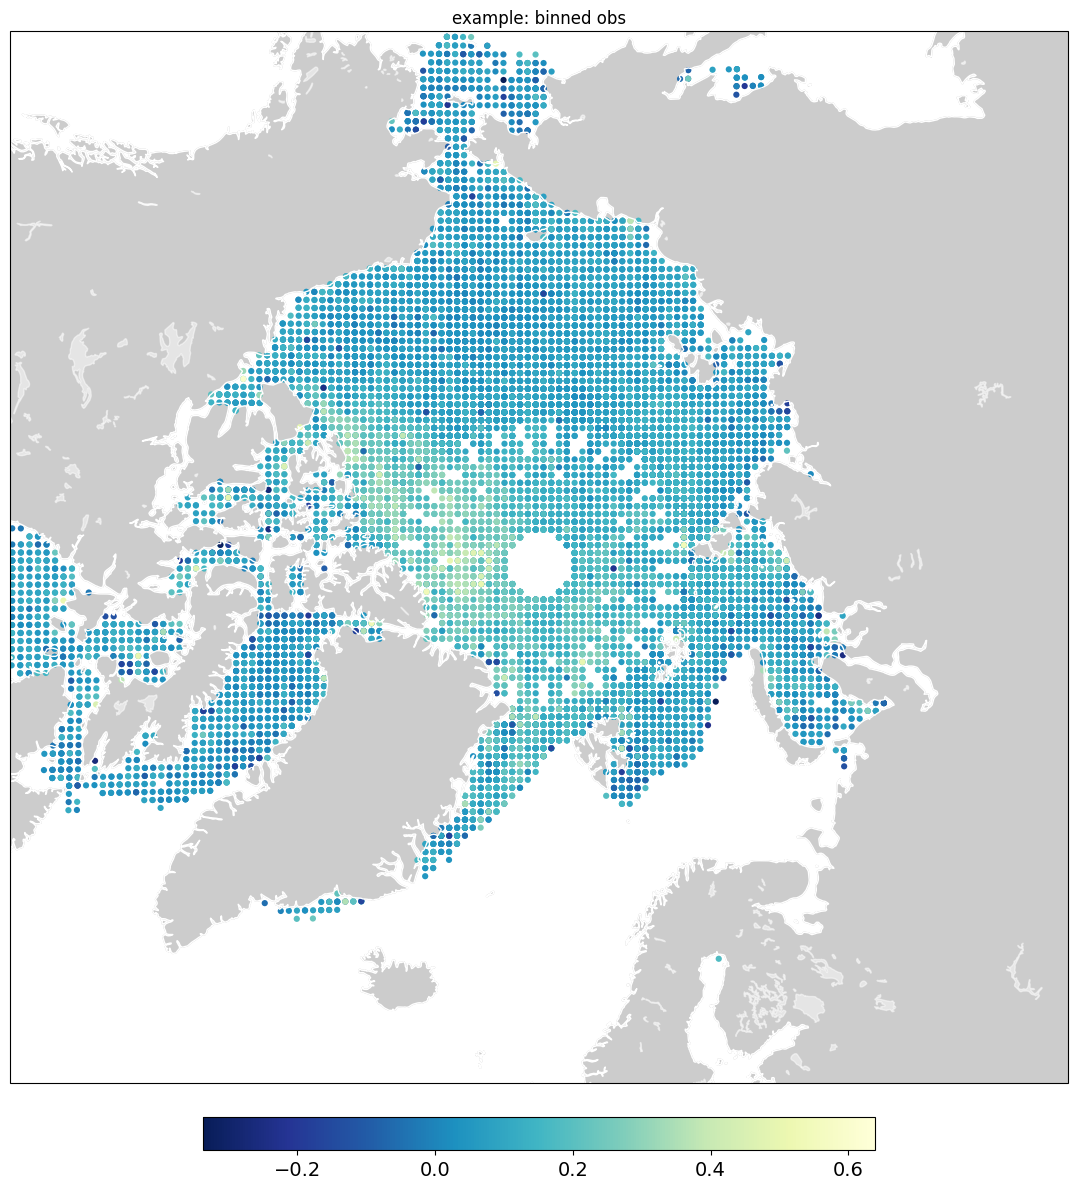

In [ ]:
# this will plot all observations, some on top of each other
bin_df['lon'], bin_df['lat'] = EASE2toWGS84_New(bin_df['x'], bin_df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=bin_df['lon'],
                lat=bin_df['lat'],
                plot_data=bin_df['z'],
                title="example: binned obs",
                scatter=True,
                s=20,
                fig=fig,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

# expert locations - on evenly spaced grid


In [ ]:
# - spaced every 200km for some x,y range
xy_grid = grid_2d_flatten(x_range=[-500000.0, 500000.0],
                          y_range=[-500000.0, 500000.0],
                          step_size=200_000)

# store in dataframe
eloc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# add a time coordinate
eloc['t'] = np.floor(df['t'].mean())


# plot expert locations


'plot_pcolormesh': 0.026 seconds


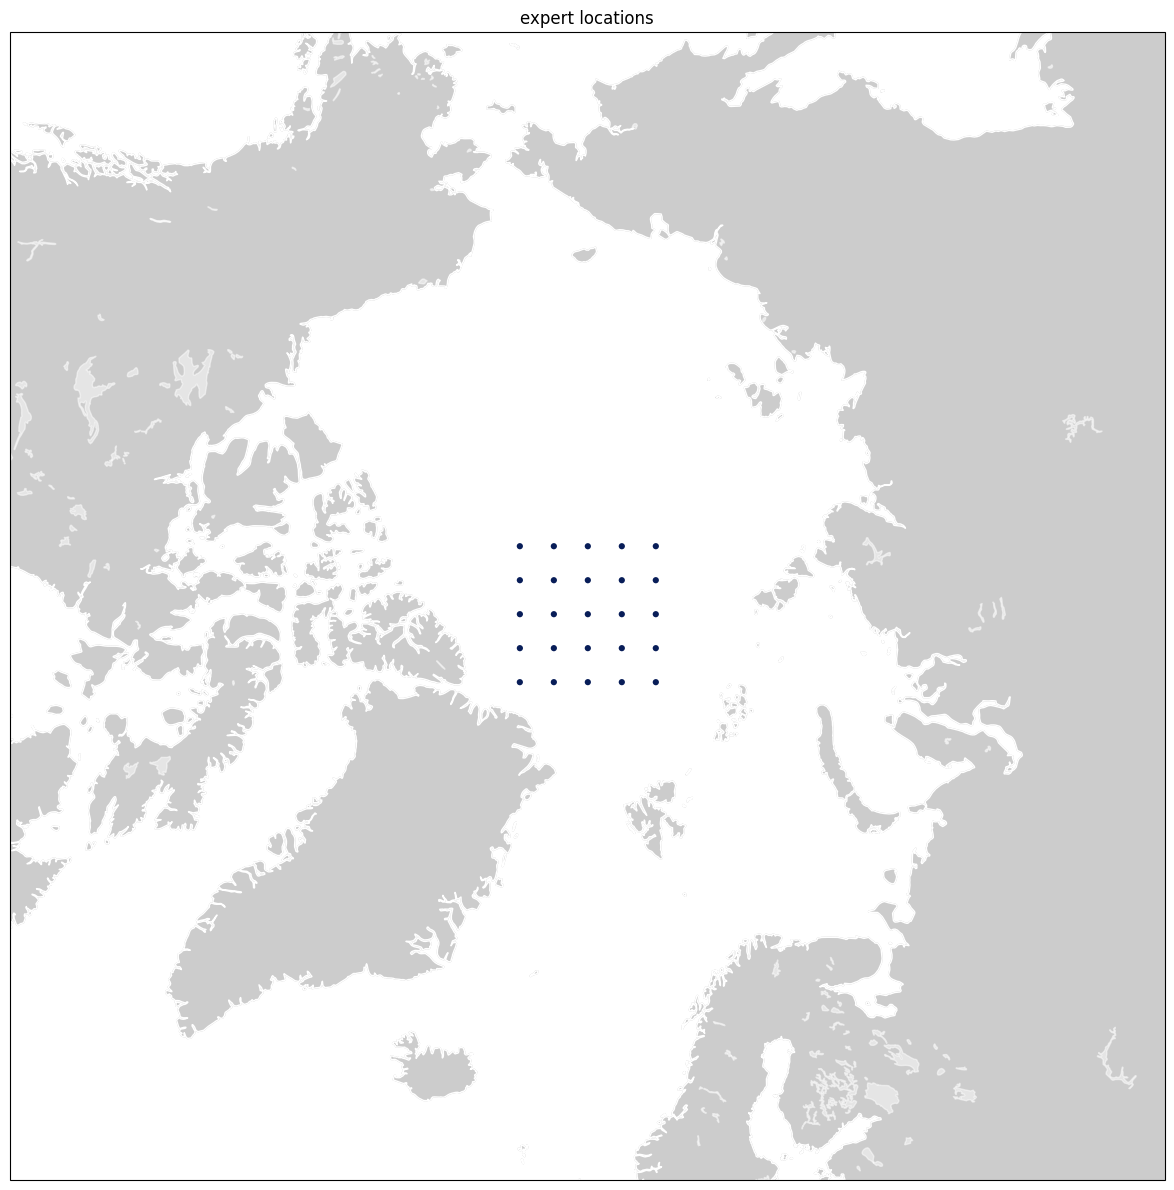

In [ ]:

eloc['lon'], eloc['lat'] = EASE2toWGS84_New(eloc['x'], eloc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=eloc['lon'],
                lat=eloc['lat'],
                plot_data=eloc['t'],
                title="expert locations",
                scatter=True,
                s=20,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()


# prediction locations


In [ ]:

# - spaced every 5km
xy_grid = grid_2d_flatten(x_range=[-500000.0, 500000.0],
                          y_range=[-500000.0, 500000.0],
                          step_size=5_000)

# store in dataframe
# NOTE: the missing 't' coordinate will be determine by the expert location
# - alternatively the prediction location can be specified
ploc = pd.DataFrame(xy_grid, columns=['x', 'y'])



# plot prediction locations


'plot_pcolormesh': 0.055 seconds


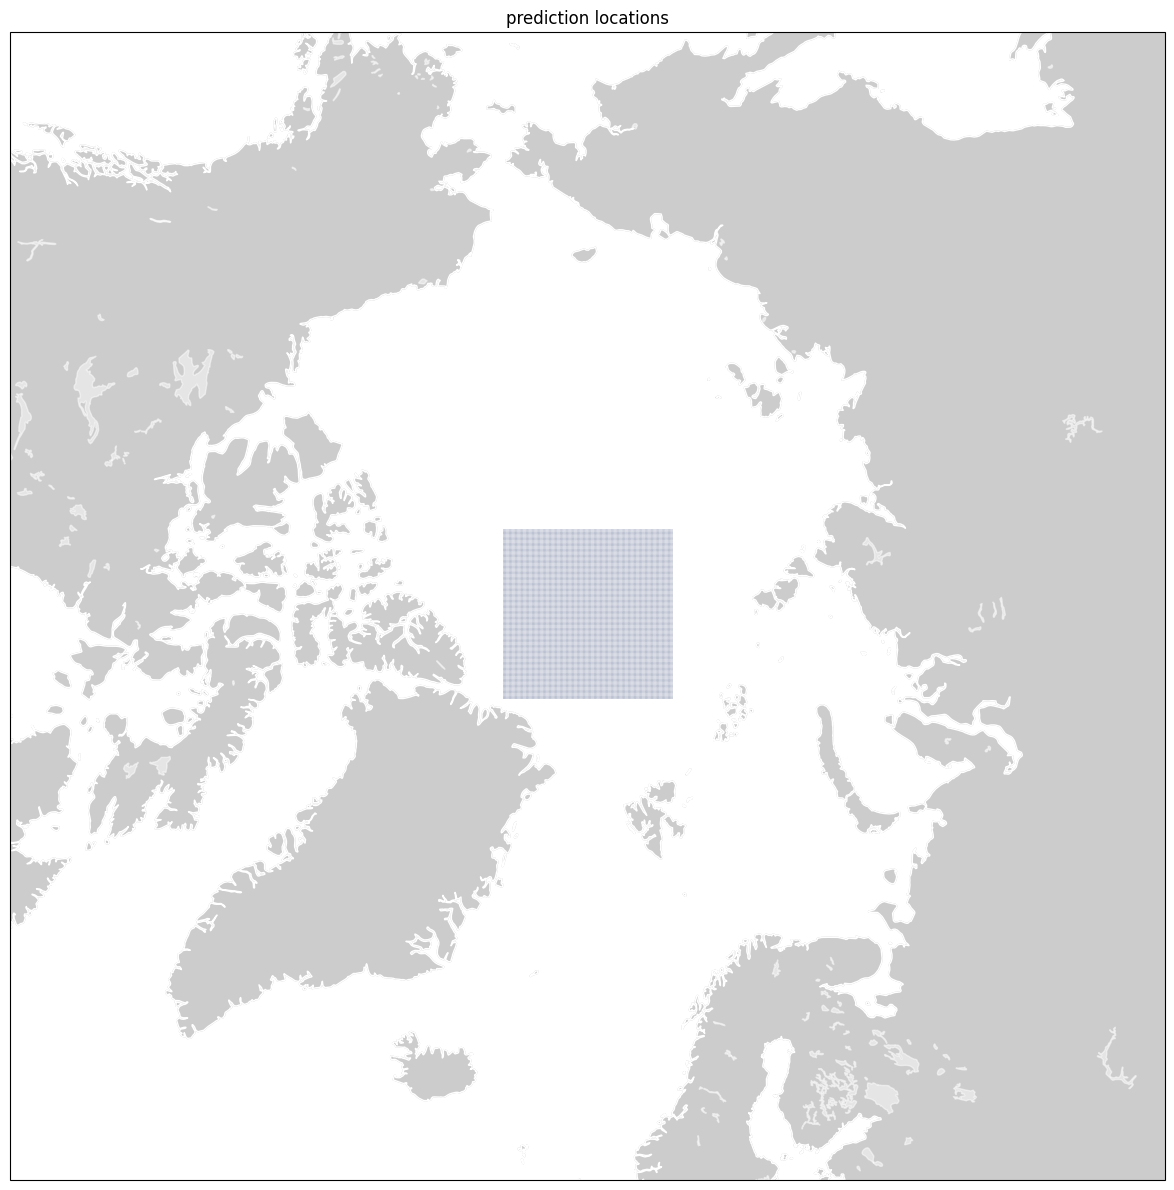

In [ ]:
ploc['lon'], ploc['lat'] = EASE2toWGS84_New(ploc['x'], ploc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=ploc['lon'],
                lat=ploc['lat'],
                plot_data=np.full(len(ploc), 1.0), #np.arange(len(ploc)),
                title="prediction locations",
                scatter=True,
                s=0.1,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()



# configurations for Local Expert OI


In [ ]:


# observation data
data = {
    "data_source": bin_df,
    "obs_col": "z",
    "coords_col": ["x", "y", "t"],
    # selection criteria used for each local expert
    "local_select": [
        {
            "col": "t",
            "comp": "<=",
            "val": 4
        },
        {
            "col": "t",
            "comp": ">=",
            "val": -4
        },
        {
            "col": [
                "x",
                "y"
            ],
            "comp": "<",
            "val": 300_000
        }
    ]
}

# local expert locations
local_expert = {
    "source": eloc
}

# model
model = {
    "oi_model": "GPflowGPRModel",
    "init_params": {
        # scale (divide) coordinates
        "coords_scale": [50000, 50000, 1]
    },
    "constraints": {
        # lengthscales - same order coord_col (see data)
        "lengthscales": {
            "low": [1e-08, 1e-08, 1e-08],
            "high": [600000, 600000, 9]
        }
    }
}

# prediction locations
# -
pred_loc = {
    "method": "from_dataframe",
    "df": ploc,
    "max_dist": 200_000
}


# Local Expert OI


In [ ]:
locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)



'data_select': 0.001 seconds
'load': 0.005 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 22522 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 40000 >  100
storing as str


# run optimal interpolation

In [ ]:
# path to store results
store_path = get_parent_path("results", "inline_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=store_path,
           optimise=True)

---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details in the file'
will now close object

--------------------------------------------------
1 / 25
current local expert:
          x         y        t   lon        lat
0 -400000.0 -400000.0  18326.0 -45.0  84.933616
'data_select': 0.002 seconds
'load': 0.003 seconds
'local_data_select': 0.009 seconds
number obs: 402
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 6.185 seconds
'get_parameters': 0.009 seconds
'set_lengthscales_constraints': 0.011 seconds
'optimise_parameters': 8.105 seconds
'get_parameters': 0.013 seconds
parameters:
lengthscales: array([5.18468509, 3.21975596, 8.99999859]) 
kernel_variance: 0.015249738948628017
likelihood_variance: 0.003326589402625765
'predict': 0.152 seconds
total run time : 15.

# results (predictions and parameters) are store in hdf5


In [ ]:

# extract, store in dict
dfs, _ = get_results_from_h5file(store_path)

print(f"tables in results file: {list(dfs.keys())}")


reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
tables in results file: ['expert_locs', 'kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details']


# plot the predictions


'data_select': 0.001 seconds
'load': 0.003 seconds
'plot_pcolormesh': 0.049 seconds


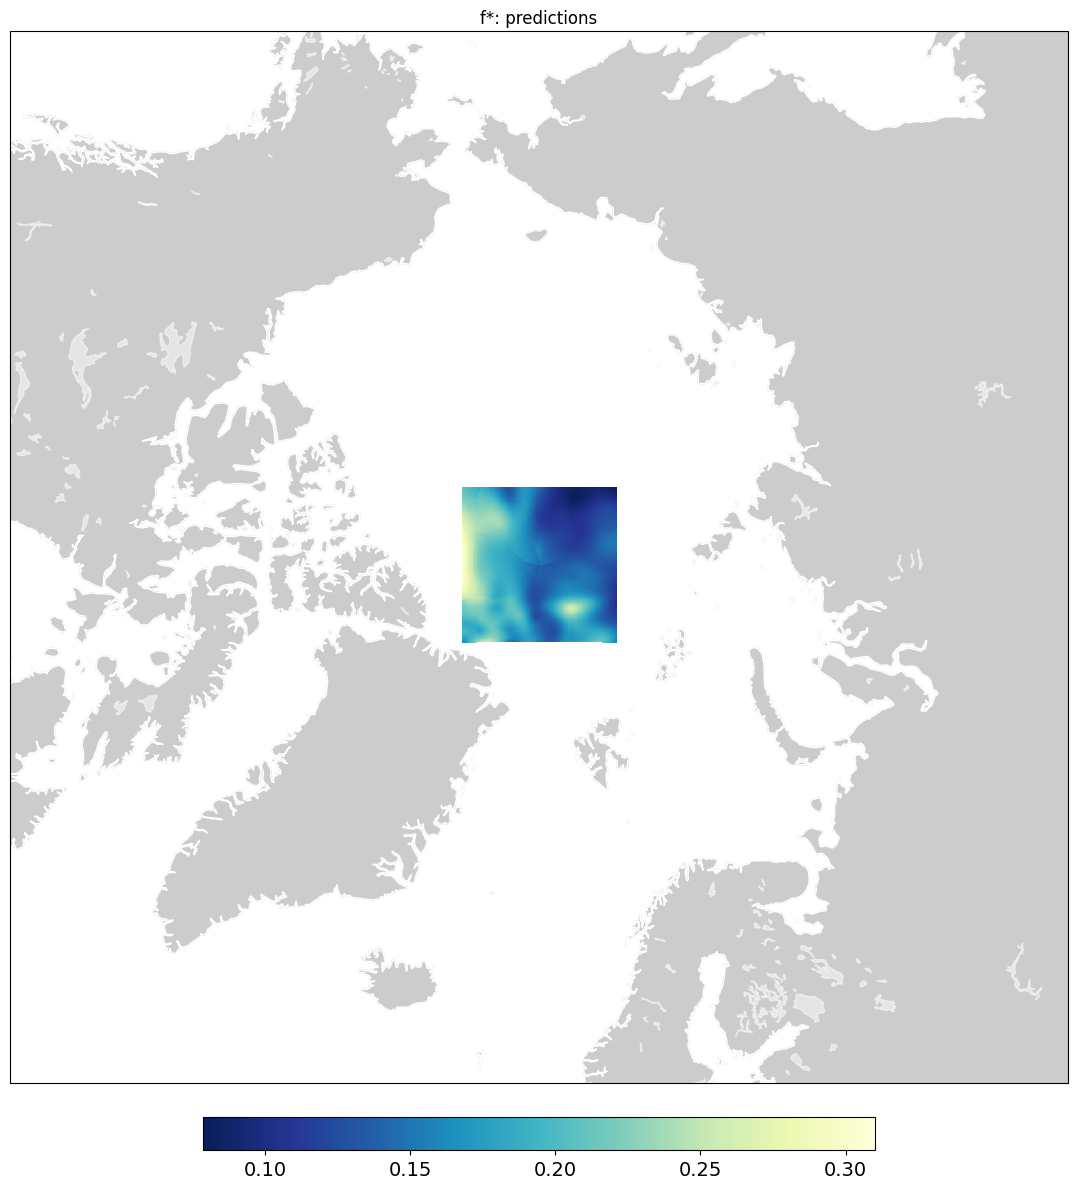

In [ ]:
plt_data = dfs["preds"]

# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.
weighted_values_kwargs = {
        "ref_col": ["pred_loc_x", "pred_loc_y", "pred_loc_t"],
        "dist_to_col": ["x", "y", "t"],
        "val_cols": ["f*", "f*_var"],
        "weight_function": "gaussian",
        "lengthscale": 200_000
    }
plt_data = get_weighted_values(df=plt_data, **weighted_values_kwargs)

# add convert x,y to lon,lat
plt_data['lon'], plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'], plt_data['pred_loc_y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))
plot_pcolormesh_from_results_data(ax=ax,
                                  dfs={"preds": plt_data},
                                  table='preds',
                                  val_col="f*",
                                  scatter=False,
                                  x_col='pred_loc_x',
                                  y_col='pred_loc_y',
                                  fig=fig,
                                  plot_kwargs={"title": "f*: predictions"})
plt.tight_layout()
plt.show()





